# Forced alignments data processing

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import subprocess
import shutil
from Bio import SeqIO
from Bio.Blast import NCBIXML
from collections import defaultdict
from scipy import stats

# Define functions


# Load data from JSON files into DataFrames
def load_json_to_df(filename):
    """
    Load data from a JSON file and return as a DataFrame.

    Parameters:
    filename (str): Path to the JSON file.

    Returns:
    pd.DataFrame: DataFrame containing data from the JSON file.
    """
    with open(filename, "r") as file:
        data = json.load(file)
    return pd.DataFrame(data)


def load_all_json_files(directory):
    """
    Loads all JSON files in a specified directory into pandas DataFrames, storing each
    DataFrame in a dictionary with keys derived from the file names.

    Parameters:
    directory (str): The directory from which to load JSON files.

    Returns:
    dict: A dictionary containing DataFrames. Keys are the file names without the '.json' extension.
    """
    data_frames = {}
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)
            data = load_json_to_df(file_path)
            # Use the file name without '.json' as the key
            key_name = filename[
                :-5
            ]  # Removes the last 5 characters, which should be ".json"
            data_frames[key_name] = pd.DataFrame(data)
    return data_frames

## Load data:

In [2]:
T5_data_table = load_json_to_df(
    "../my_matlab_scripts_and_exports/summary_tables_json_files/T5_data_table.json"
)
T5samplesbamids = load_json_to_df(
    "../my_matlab_scripts_and_exports/summary_tables_json_files/T5samplesbamids.json"
)

## Merging `T5_data_table` and `T5samplesbamids`to have all the T5 data in one place in long format

In [3]:
# Convert T5samplesbamids to long format
id_vars = [
    "sample_name",
    "sample_id",
    "patient_id",
    "extraction",
    "virus",
    "viral_load",
    "concentration",
]
value_vars = [
    "rep_1_precapture",
    "rep_2_precapture",
    "rep_1_G14_capture",
    "rep_2_G14_capture",
    "rep_1_G1a_capture",
    "rep_2_G1a_capture",
    "T6_G16_capture",
]
T5samplesbamids_long = pd.melt(
    T5samplesbamids,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name="seq_method",
    value_name="run_id",
)

# Check for duplicates in T5_data_table to ensure that merging based on 'sample_id', 'seq_method', 'viral_load' is reasonable
duplicate_data_table = T5_data_table.duplicated(
    subset=["sample_id", "seq_method", "viral_load"], keep=False
)

# Check for duplicates in T5samplesbamids_long to ensure that merging based on 'sample_id', 'seq_method', 'viral_load' is reasonable
duplicate_samplesbamids = T5samplesbamids_long.duplicated(
    subset=["sample_id", "seq_method", "viral_load"], keep=False
)

# Check whether duplicates where found or not and go ahead with merging if there aren't any
if not duplicate_data_table.any() and not duplicate_samplesbamids.any():
    print(
        "No duplicates found, the chosen columns are appropriate for merging the dataframes."
    )

    # Merge the data tables on 'sample_id', 'seq_method', and 'viral_load'
    all_T5_data_long = pd.merge(
        T5_data_table,
        T5samplesbamids_long,
        on=["sample_id", "seq_method", "viral_load"],
        how="left",
    )  # include all rows from T5_data_table and match them with those from T5samplesbamids_long (I think this is the right option to choose but am slightly unsure)

    # Display the structure of the merged data
    print("\nHead of all_T5_data_long:")
    print(all_T5_data_long.head())
else:
    if duplicate_data_table.any():
        print(
            "Duplicates found in T5_data_table based on ['sample_id', 'seq_method', 'viral_load']:"
        )
        print(T5_data_table[duplicate_data_table])
    if duplicate_samplesbamids.any():
        print(
            "Duplicates found in T5samplesbamids_long based on ['sample_id', 'seq_method', 'viral_load']:"
        )
        print(T5samplesbamids_long[duplicate_samplesbamids])

No duplicates found, the chosen columns are appropriate for merging the dataframes.

Head of all_T5_data_long:
  sample_name_x         seq_method sample_id patient_id_x  viral_load  \
0       030-031   rep_1_precapture   030-031      030-031     19256.0   
1       030-031   rep_2_precapture   030-031      030-031     19256.0   
2       030-031  rep_1_G14_capture   030-031      030-031     19256.0   
3       030-031  rep_2_G14_capture   030-031      030-031     19256.0   
4       030-031  rep_1_G1a_capture   030-031      030-031     19256.0   

   num_total_reads  num_total_reads_cleaned  num_reads_mapped_to_human  \
0        7840314.0                7494972.0                  7265681.0   
1        8668044.0                8241300.0                  8006237.0   
2          78574.0                  77236.0                    64409.0   
3          83042.0                  81260.0                    69519.0   
4          19824.0                  19560.0                     4928.0   

   nu

## Filter high VL samples

The first thing happening in Azim's MATLAB code for plotting the capture efficiency figure is sorting `T5samplesbamids` by the highest viral loads and then taking just the first 15 rows (samples) with the highest viral loads (although one row is skipped). From what I understand from the comments in Azim's code, for these 15 samples, whole genome assemblies are available for both the direct MGS and capture with 1a probes approaches. Presumably, for the row that is skipped, no full assemblies were available (but I don't know). I replicate this by sorting and filtering `all_T5_data_long` accordingly.

In [4]:
# Sort the merged DataFrame by 'viral_load' in descending order
sorted_by_highest_viral_loads = all_T5_data_long.sort_values(
    by="viral_load", ascending=False
)

# Use this to select the top 15 high VL samples just like Azim did in his MATLAB code
# Select the top 15 unique sample_ids with the highest viral loads, skipping one row
top_15_sample_ids = pd.concat(
    [
        sorted_by_highest_viral_loads.drop_duplicates(subset="sample_id").head(14),
        sorted_by_highest_viral_loads.drop_duplicates(subset="sample_id").iloc[15:16],
    ]
)["sample_id"]

# Filter the combined data to include only the top 15 sample_ids
high_VL_samples = all_T5_data_long[
    all_T5_data_long["sample_id"].isin(top_15_sample_ids)
]

# Further filter to include only rows with 'seq_method' values 'rep_2_precapture' and 'rep_2_G1a_capture'.
high_VL_samples = high_VL_samples[
    high_VL_samples["seq_method"].isin(["rep_2_precapture", "rep_2_G1a_capture"])
]

# # Keep only the columns that are important for the downstream analysis
# high_VL_samples_filtered = high_VL_samples[
#     [
#         "sample_id",
#         "seq_method",
#         "run_id",
#         "viral_load",
#         "closest_ref",
#         "coverage",
#         "q50_major_type",
#     ]
# ]

# # Sort data frame and reset index values
# high_VL_samples_filtered = high_VL_samples_filtered.sort_values(
#     by=["viral_load", "sample_id", "seq_method"], ascending=False
# ).reset_index(drop=True)

# # Display the structure of high_VL_samples_filtered
# print("Head of high_VL_samples_filtered:")
# print(high_VL_samples_filtered.head())

## Plotting viral load vs. on-target reads

In [5]:
unique_seq_methods = all_T5_data_long["seq_method"].unique()
print("Unique values in seq_method column:")
for method in unique_seq_methods:
    print(method)

Unique values in seq_method column:
rep_1_precapture
rep_2_precapture
rep_1_G14_capture
rep_2_G14_capture
rep_1_G1a_capture
rep_2_G1a_capture
T6_G16_capture


## Proportion of HCV reads vs. viral load

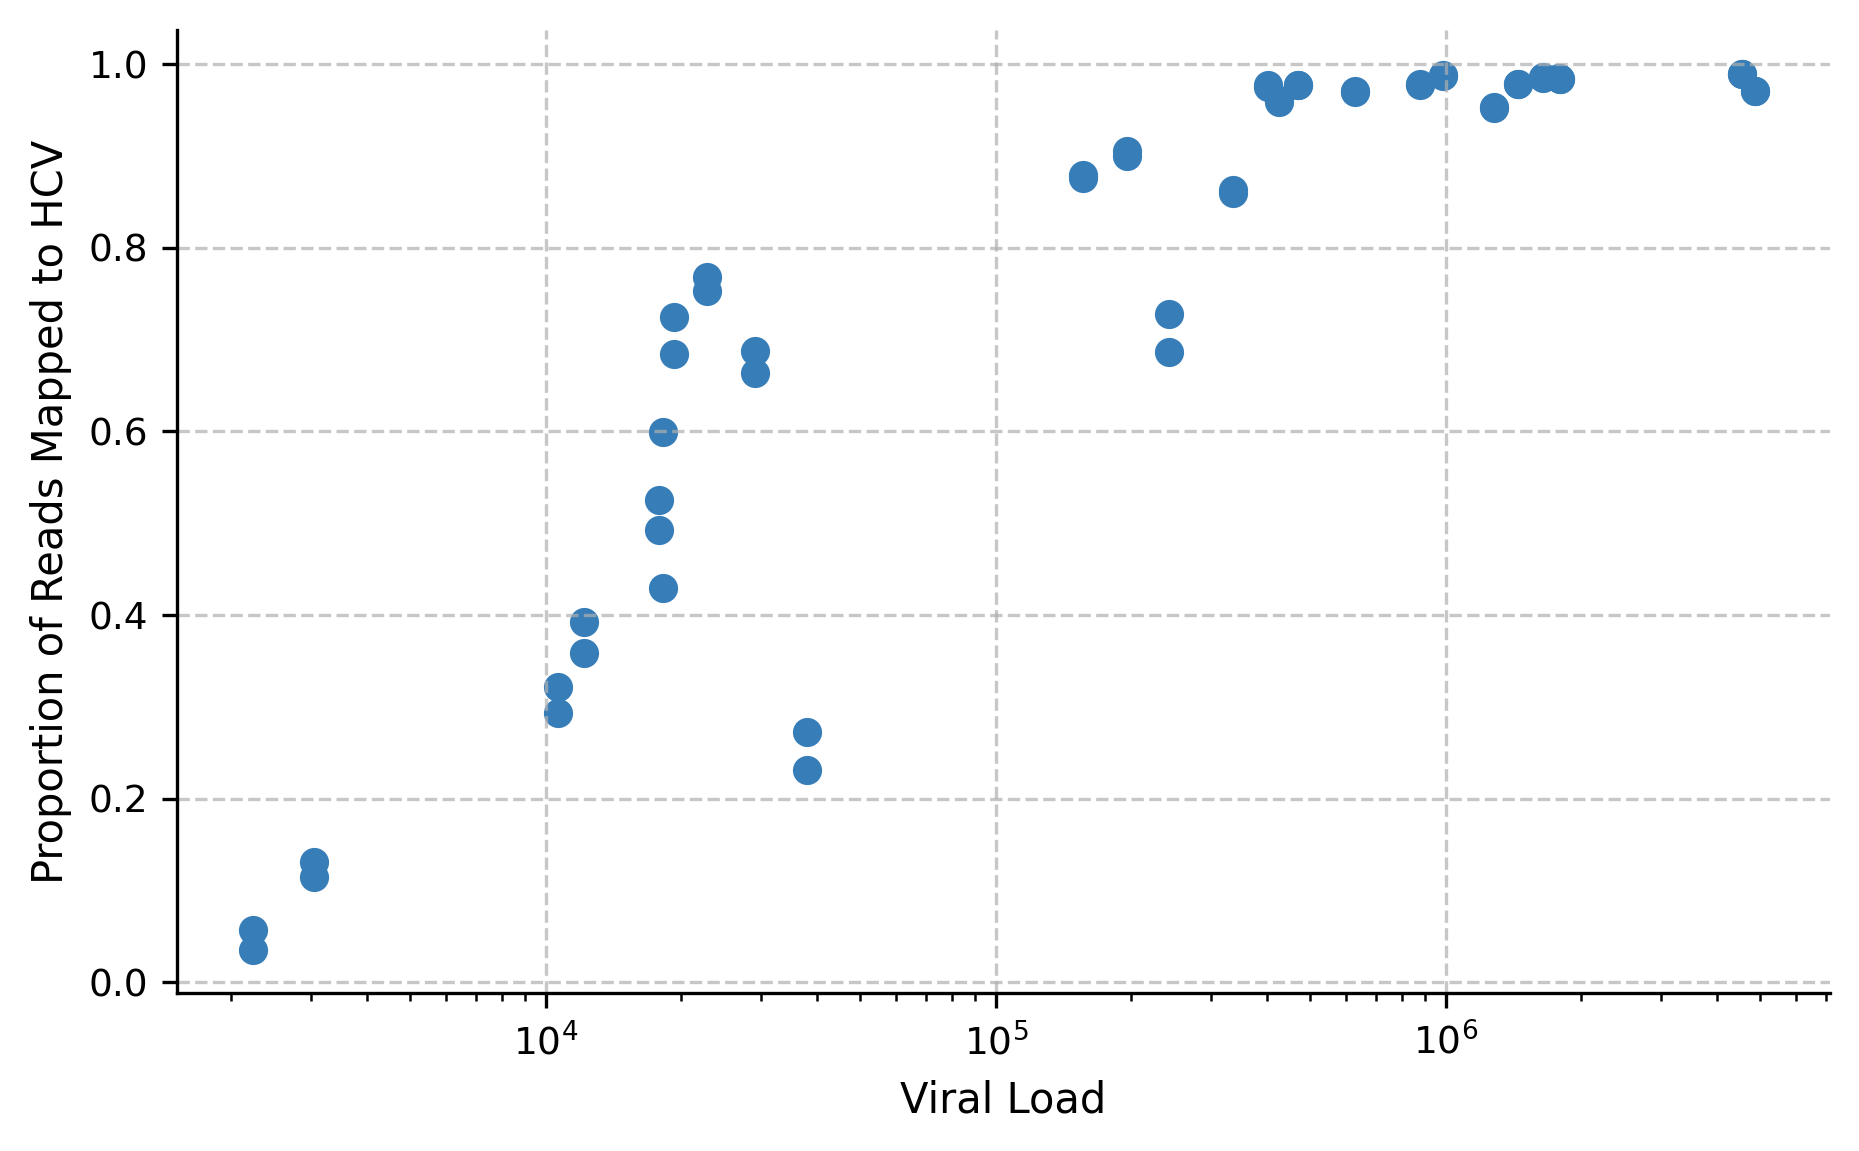

In [6]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

# Set color scheme
CB_color_cycle = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]
plt.rc("axes", prop_cycle=plt.cycler("color", CB_color_cycle))

df = all_T5_data_long[
    all_T5_data_long["seq_method"].isin(["rep_2_G1a_capture", "rep_1_G1a_capture"])
]
# Sort the data by viral_load
df = df.sort_values("viral_load")

# Create the plot
centimeters = 1 / 2.54  # centimeters in inches

plt.figure(figsize=(16 * centimeters, 10 * centimeters), dpi=300)
plt.scatter(df["viral_load"], df["prop_hcv_all"], color="C0")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Viral Load")
plt.ylabel("Proportion of Reads Mapped to HCV")
plt.xscale("log")
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

## Total number of HCV reads vs. viral load

         viral_load  num_reads_mapped_to_HCV
count  5.400000e+01             5.400000e+01
mean   8.240225e+05             2.906912e+05
std    1.255619e+06             4.357244e+05
min    2.230000e+03             1.860000e+02
25%    2.013050e+04             1.059950e+04
50%    3.358420e+05             7.401800e+04
75%    1.204402e+06             4.299965e+05
max    4.854384e+06             1.997758e+06

Number of NaN values:
viral_load                 0
num_reads_mapped_to_HCV    0
dtype: int64


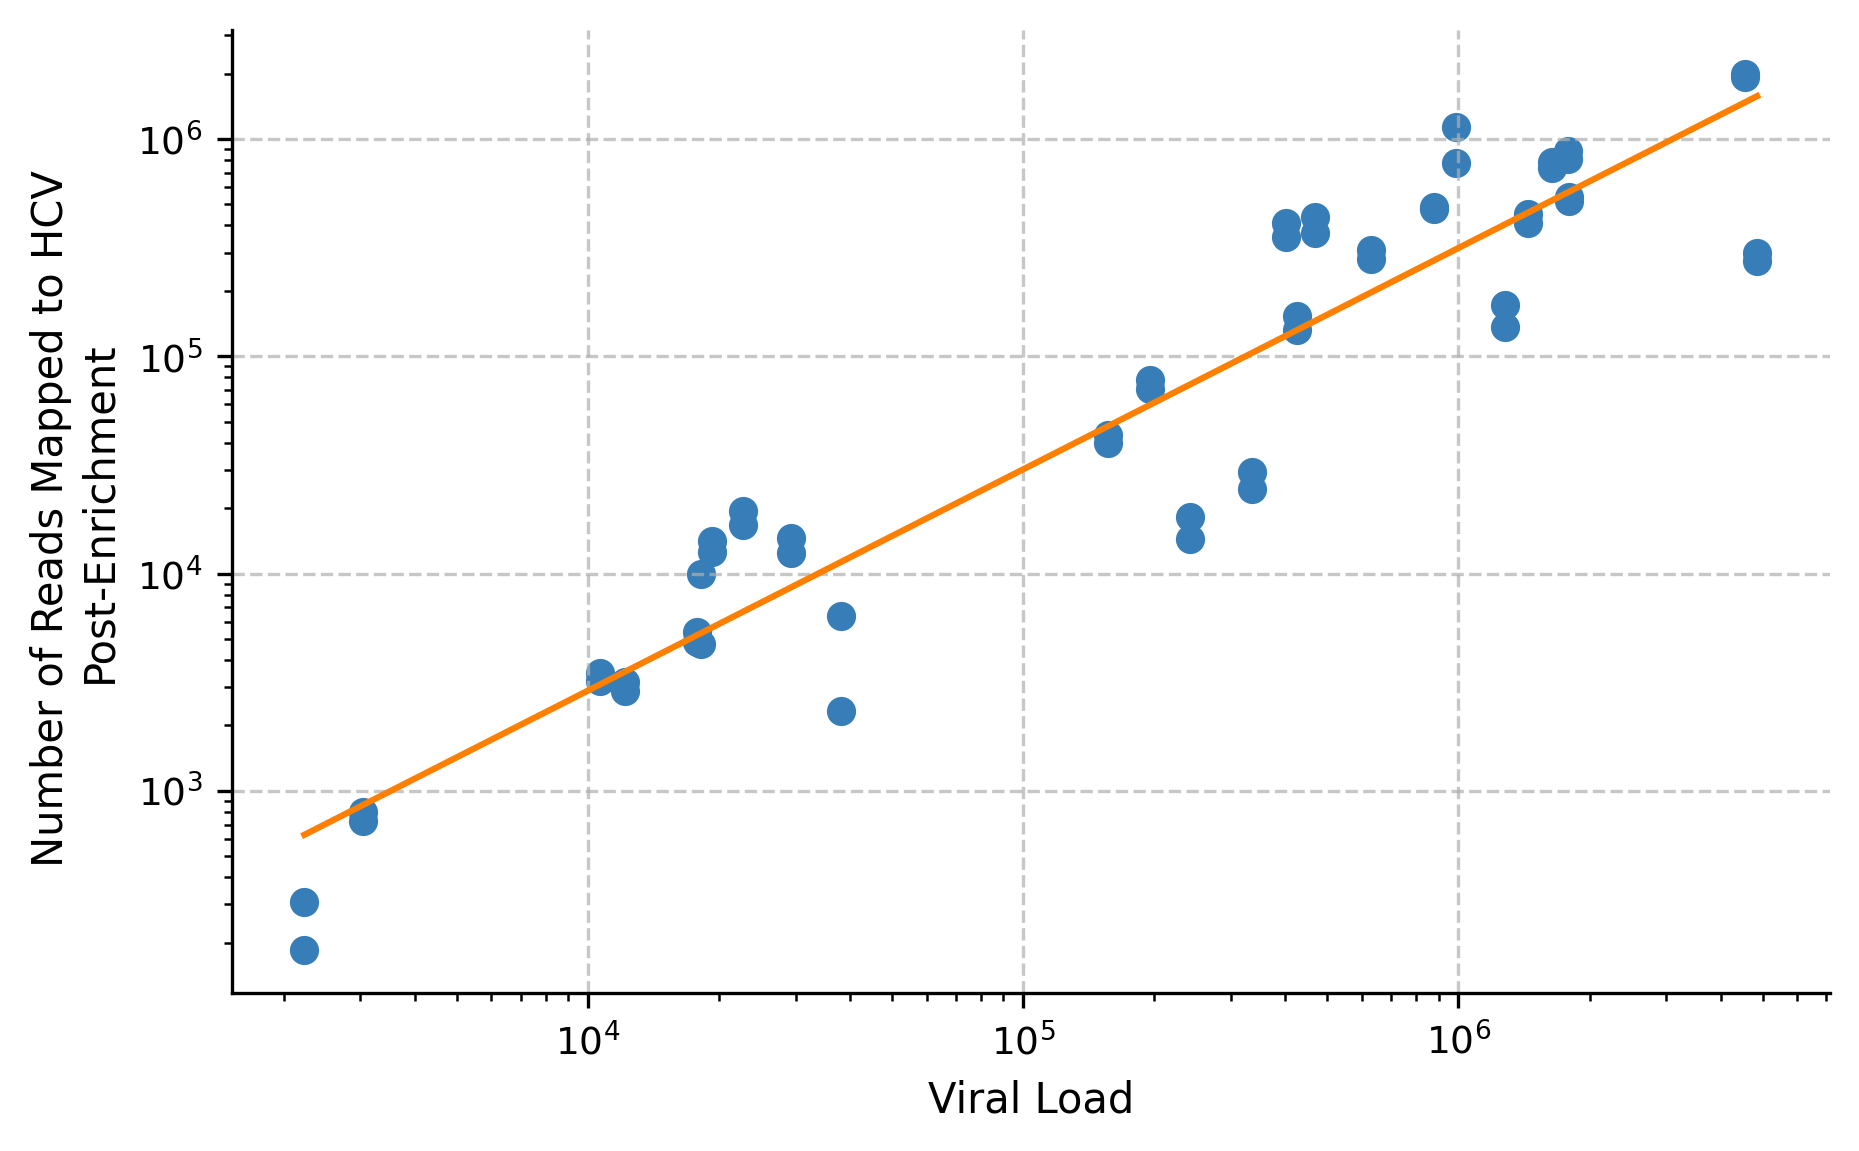


Log-log regression equation: y = 1.0185x + -0.6125
R-squared: 0.8883
p-value: 0.0000


In [7]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

df = all_T5_data_long[
    all_T5_data_long["seq_method"].isin(["rep_2_G1a_capture", "rep_1_G1a_capture"])
]

# Remove rows with NaN values for viral load
df = df.dropna(subset=["viral_load"])

# Print data summary
print(df[["viral_load", "num_reads_mapped_to_HCV"]].describe())
print("\nNumber of NaN values:")
print(df[["viral_load", "num_reads_mapped_to_HCV"]].isnull().sum())

# Create the plot
centimeters = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(16 * centimeters, 10 * centimeters), dpi=300)

# Scatter plot
plt.scatter(df["viral_load"], df["num_reads_mapped_to_HCV"], color="C0")

# Linear regression
x = np.log10(df["viral_load"])
y = np.log10(df["num_reads_mapped_to_HCV"])

# Use scipy's linregress for linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot the regression line
x_range = np.logspace(
    np.log10(df["viral_load"].min()), np.log10(df["viral_load"].max()), 100
)
plt.plot(x_range, 10 ** (slope * np.log10(x_range) + intercept), color="C1")

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Viral Load")
plt.ylabel("Number of Reads Mapped to HCV \nPost-Enrichment")
plt.xscale("log")
plt.yscale("log")

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# Print the regression statistics
print(f"\nLog-log regression equation: y = {slope:.4f}x + {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4f}")

## Human reads vs. viral load

         viral_load  num_reads_mapped_to_human
count  5.400000e+01                  54.000000
mean   8.240225e+05                6250.574074
std    1.255619e+06                2318.965479
min    2.230000e+03                3396.000000
25%    2.013050e+04                5178.500000
50%    3.358420e+05                5887.000000
75%    1.204402e+06                6929.250000
max    4.854384e+06               20481.000000

Number of NaN values:
viral_load                   0
num_reads_mapped_to_human    0
dtype: int64


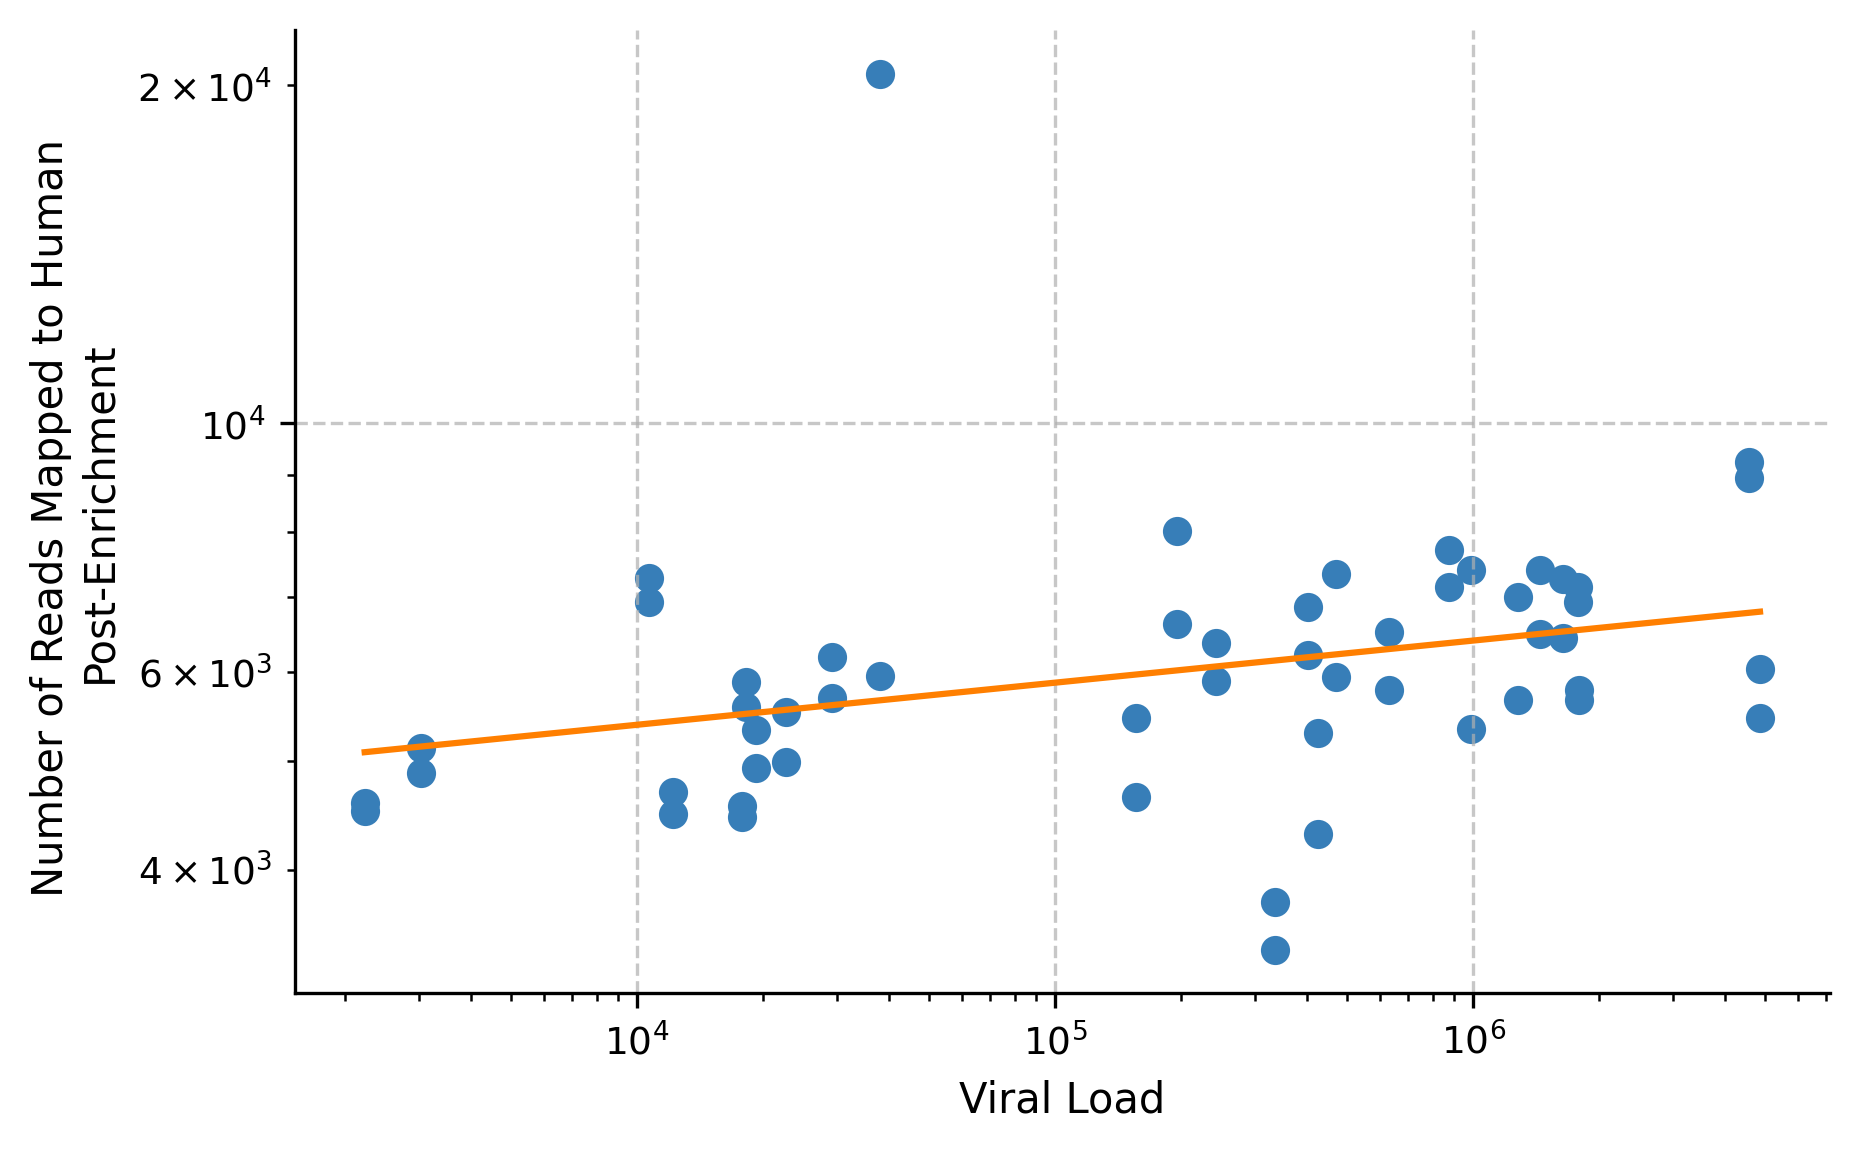


Log-log regression equation: y = 0.0375x + 3.5812
R-squared: 0.0976
p-value: 0.0215


In [8]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

df = all_T5_data_long[
    all_T5_data_long["seq_method"].isin(["rep_2_G1a_capture", "rep_1_G1a_capture"])
]

# Remove rows with NaN values for viral load
df = df.dropna(subset=["viral_load"])

# Print data summary
print(df[["viral_load", "num_reads_mapped_to_human"]].describe())
print("\nNumber of NaN values:")
print(df[["viral_load", "num_reads_mapped_to_human"]].isnull().sum())

# Create the plot
centimeters = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(16 * centimeters, 10 * centimeters), dpi=300)

# Scatter plot
plt.scatter(df["viral_load"], df["num_reads_mapped_to_human"], color="C0")

# Linear regression
x = np.log10(df["viral_load"])
y = np.log10(df["num_reads_mapped_to_human"])

# Use scipy's linregress for linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot the regression line
x_range = np.logspace(
    np.log10(df["viral_load"].min()), np.log10(df["viral_load"].max()), 100
)
plt.plot(x_range, 10 ** (slope * np.log10(x_range) + intercept), color="C1")

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Viral Load")
plt.ylabel("Number of Reads Mapped to Human \nPost-Enrichment")
plt.xscale("log")
plt.yscale("log")

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# Print the regression statistics
print(f"\nLog-log regression equation: y = {slope:.4f}x + {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4f}")

## Non-HCV reads vs. viral load

         viral_load  num_reads_cleaned_not_mapped_to_HCV
count  5.400000e+01                            54.000000
mean   8.240225e+05                          8454.833333
std    1.255619e+06                          3918.352743
min    2.230000e+03                          3893.000000
25%    2.013050e+04                          5647.500000
50%    3.358420e+05                          7360.000000
75%    1.204402e+06                          9648.000000
max    4.854384e+06                         21406.000000

Number of NaN values:
viral_load                             0
num_reads_cleaned_not_mapped_to_HCV    0
dtype: int64


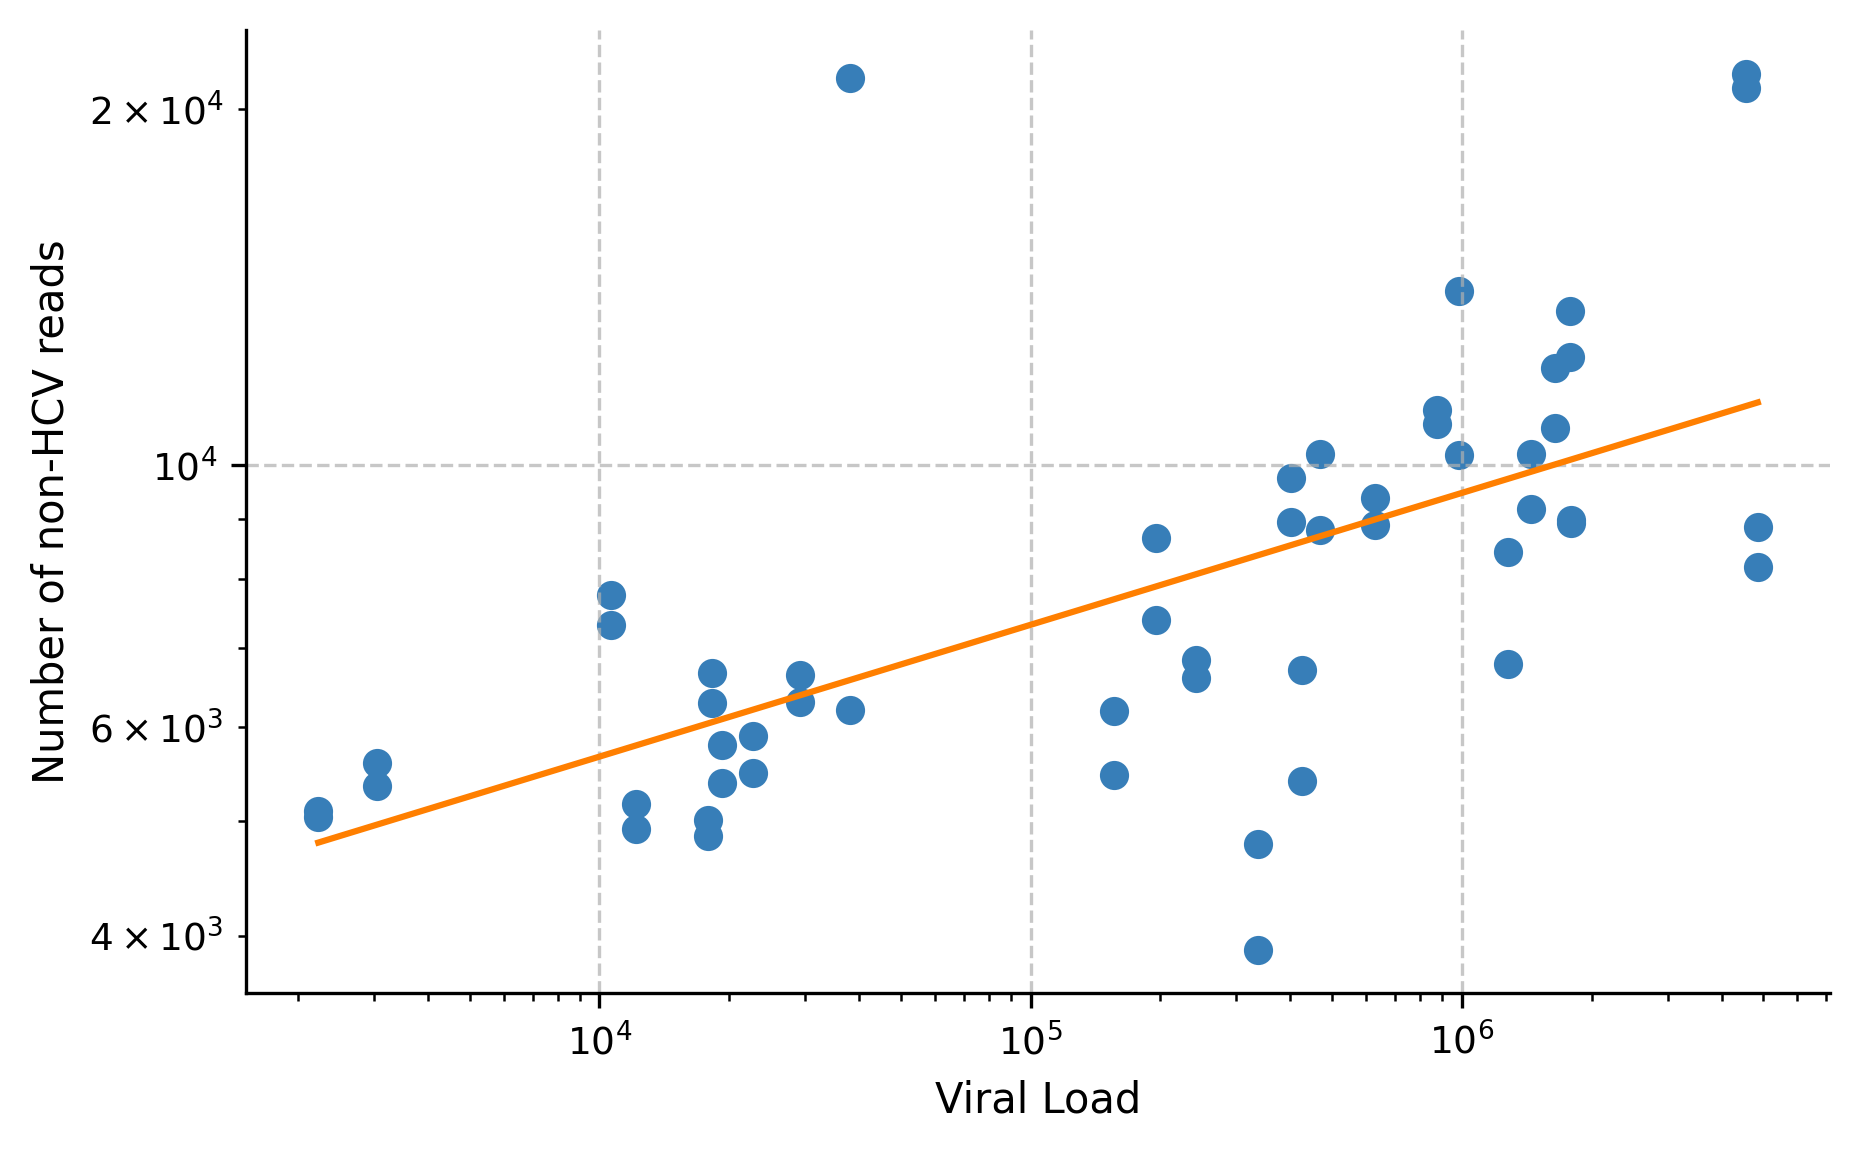


Log-log regression equation: y = 0.1114x + 3.3075
R-squared: 0.4081
p-value: 0.0000


In [9]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

# Create an explicit copy of the filtered DataFrame
df = all_T5_data_long[
    all_T5_data_long["seq_method"].isin(["rep_2_G1a_capture", "rep_1_G1a_capture"])
].copy()

# Add new columns using loc to avoid the warning
df.loc[:, "num_reads_not_mapped_to_HCV"] = (
    df["num_total_reads"] - df["num_reads_mapped_to_HCV"]
)
df.loc[:, "num_reads_cleaned_not_mapped_to_HCV"] = (
    df["num_total_reads_cleaned"] - df["num_reads_mapped_to_HCV"]
)

# Remove only rows with NaN in viral_load
df = df.dropna(subset=["viral_load"])

# Print data summary
print(df[["viral_load", "num_reads_cleaned_not_mapped_to_HCV"]].describe())
print("\nNumber of NaN values:")
print(df[["viral_load", "num_reads_cleaned_not_mapped_to_HCV"]].isnull().sum())

# Create the plot
centimeters = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(16 * centimeters, 10 * centimeters), dpi=300)

# Scatter plot
plt.scatter(df["viral_load"], df["num_reads_cleaned_not_mapped_to_HCV"], color="C0")

# Linear regression
x = np.log10(df["viral_load"])
y = np.log10(df["num_reads_cleaned_not_mapped_to_HCV"])

# Use scipy's linregress for linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot the regression line
x_range = np.logspace(
    np.log10(df["viral_load"].min()), np.log10(df["viral_load"].max()), 100
)
plt.plot(x_range, 10 ** (slope * np.log10(x_range) + intercept), color="C1")

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Viral Load")
plt.ylabel("Number of non-HCV reads")
plt.xscale("log")
plt.yscale("log")

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# Print the regression statistics
print(f"\nLog-log regression equation: y = {slope:.4f}x + {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4f}")

## Proportion of HCV reads before vs. after enrichment

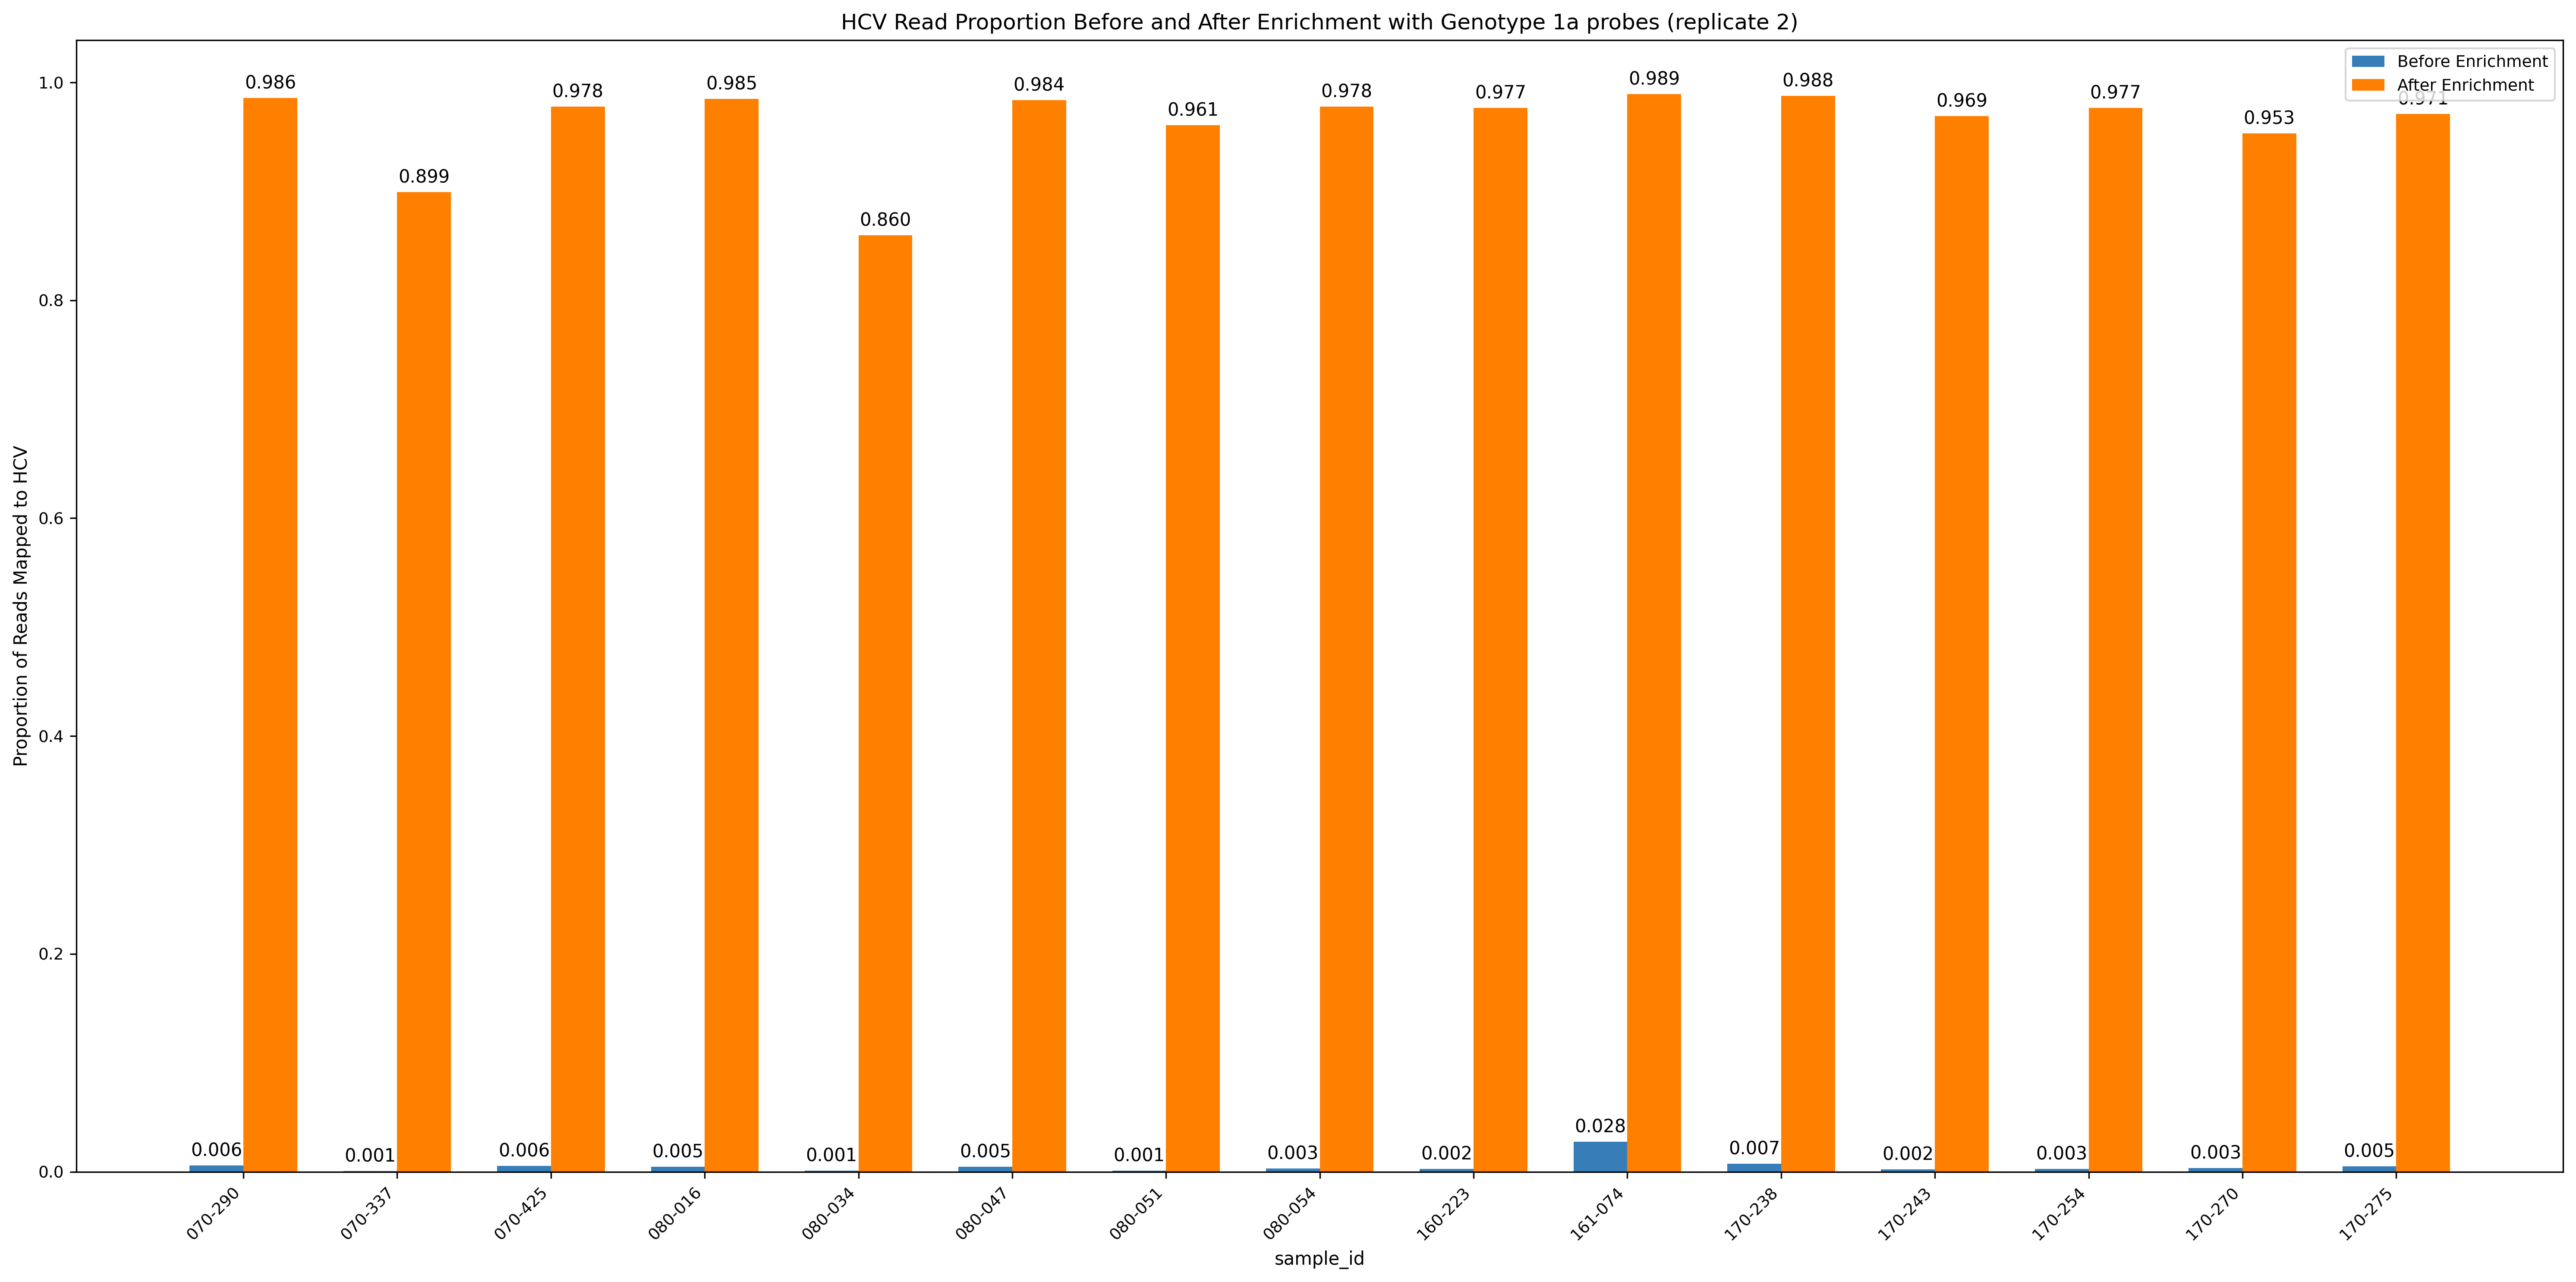

In [10]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

# Filter the data for the specific seq_methods
before_enrichment = high_VL_samples[high_VL_samples["seq_method"] == "rep_2_precapture"]
after_enrichment = high_VL_samples[high_VL_samples["seq_method"] == "rep_2_G1a_capture"]

# Ensure we have matching samples in both datasets
samples = sorted(
    set(before_enrichment["sample_id"]) & set(after_enrichment["sample_id"])
)

# Prepare data for plotting
x = np.arange(len(samples))  # the label locations
width = 0.35  # the width of the bars

before_values = [
    before_enrichment[before_enrichment["sample_id"] == sample]["prop_hcv_all"].values[
        0
    ]
    for sample in samples
]
after_values = [
    after_enrichment[after_enrichment["sample_id"] == sample]["prop_hcv_all"].values[0]
    for sample in samples
]

centimeters = 1 / 2.54  # centimeters in inches

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)

# Create the bars
rects1 = ax.bar(x - width / 2, before_values, width, label="Before Enrichment")
rects2 = ax.bar(x + width / 2, after_values, width, label="After Enrichment")

# Customize the axis
ax.set_xlabel("sample_id")
ax.set_ylabel("Proportion of Reads Mapped to HCV")
ax.set_title(
    "HCV Read Proportion Before and After Enrichment with Genotype 1a probes (replicate 2)"
)
ax.set_xticks(x)
ax.set_xticklabels(samples, rotation=45, ha="right")
ax.legend()


# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.3f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)

# Adjust layout and display
fig.tight_layout()
plt.show()

### publication ready version

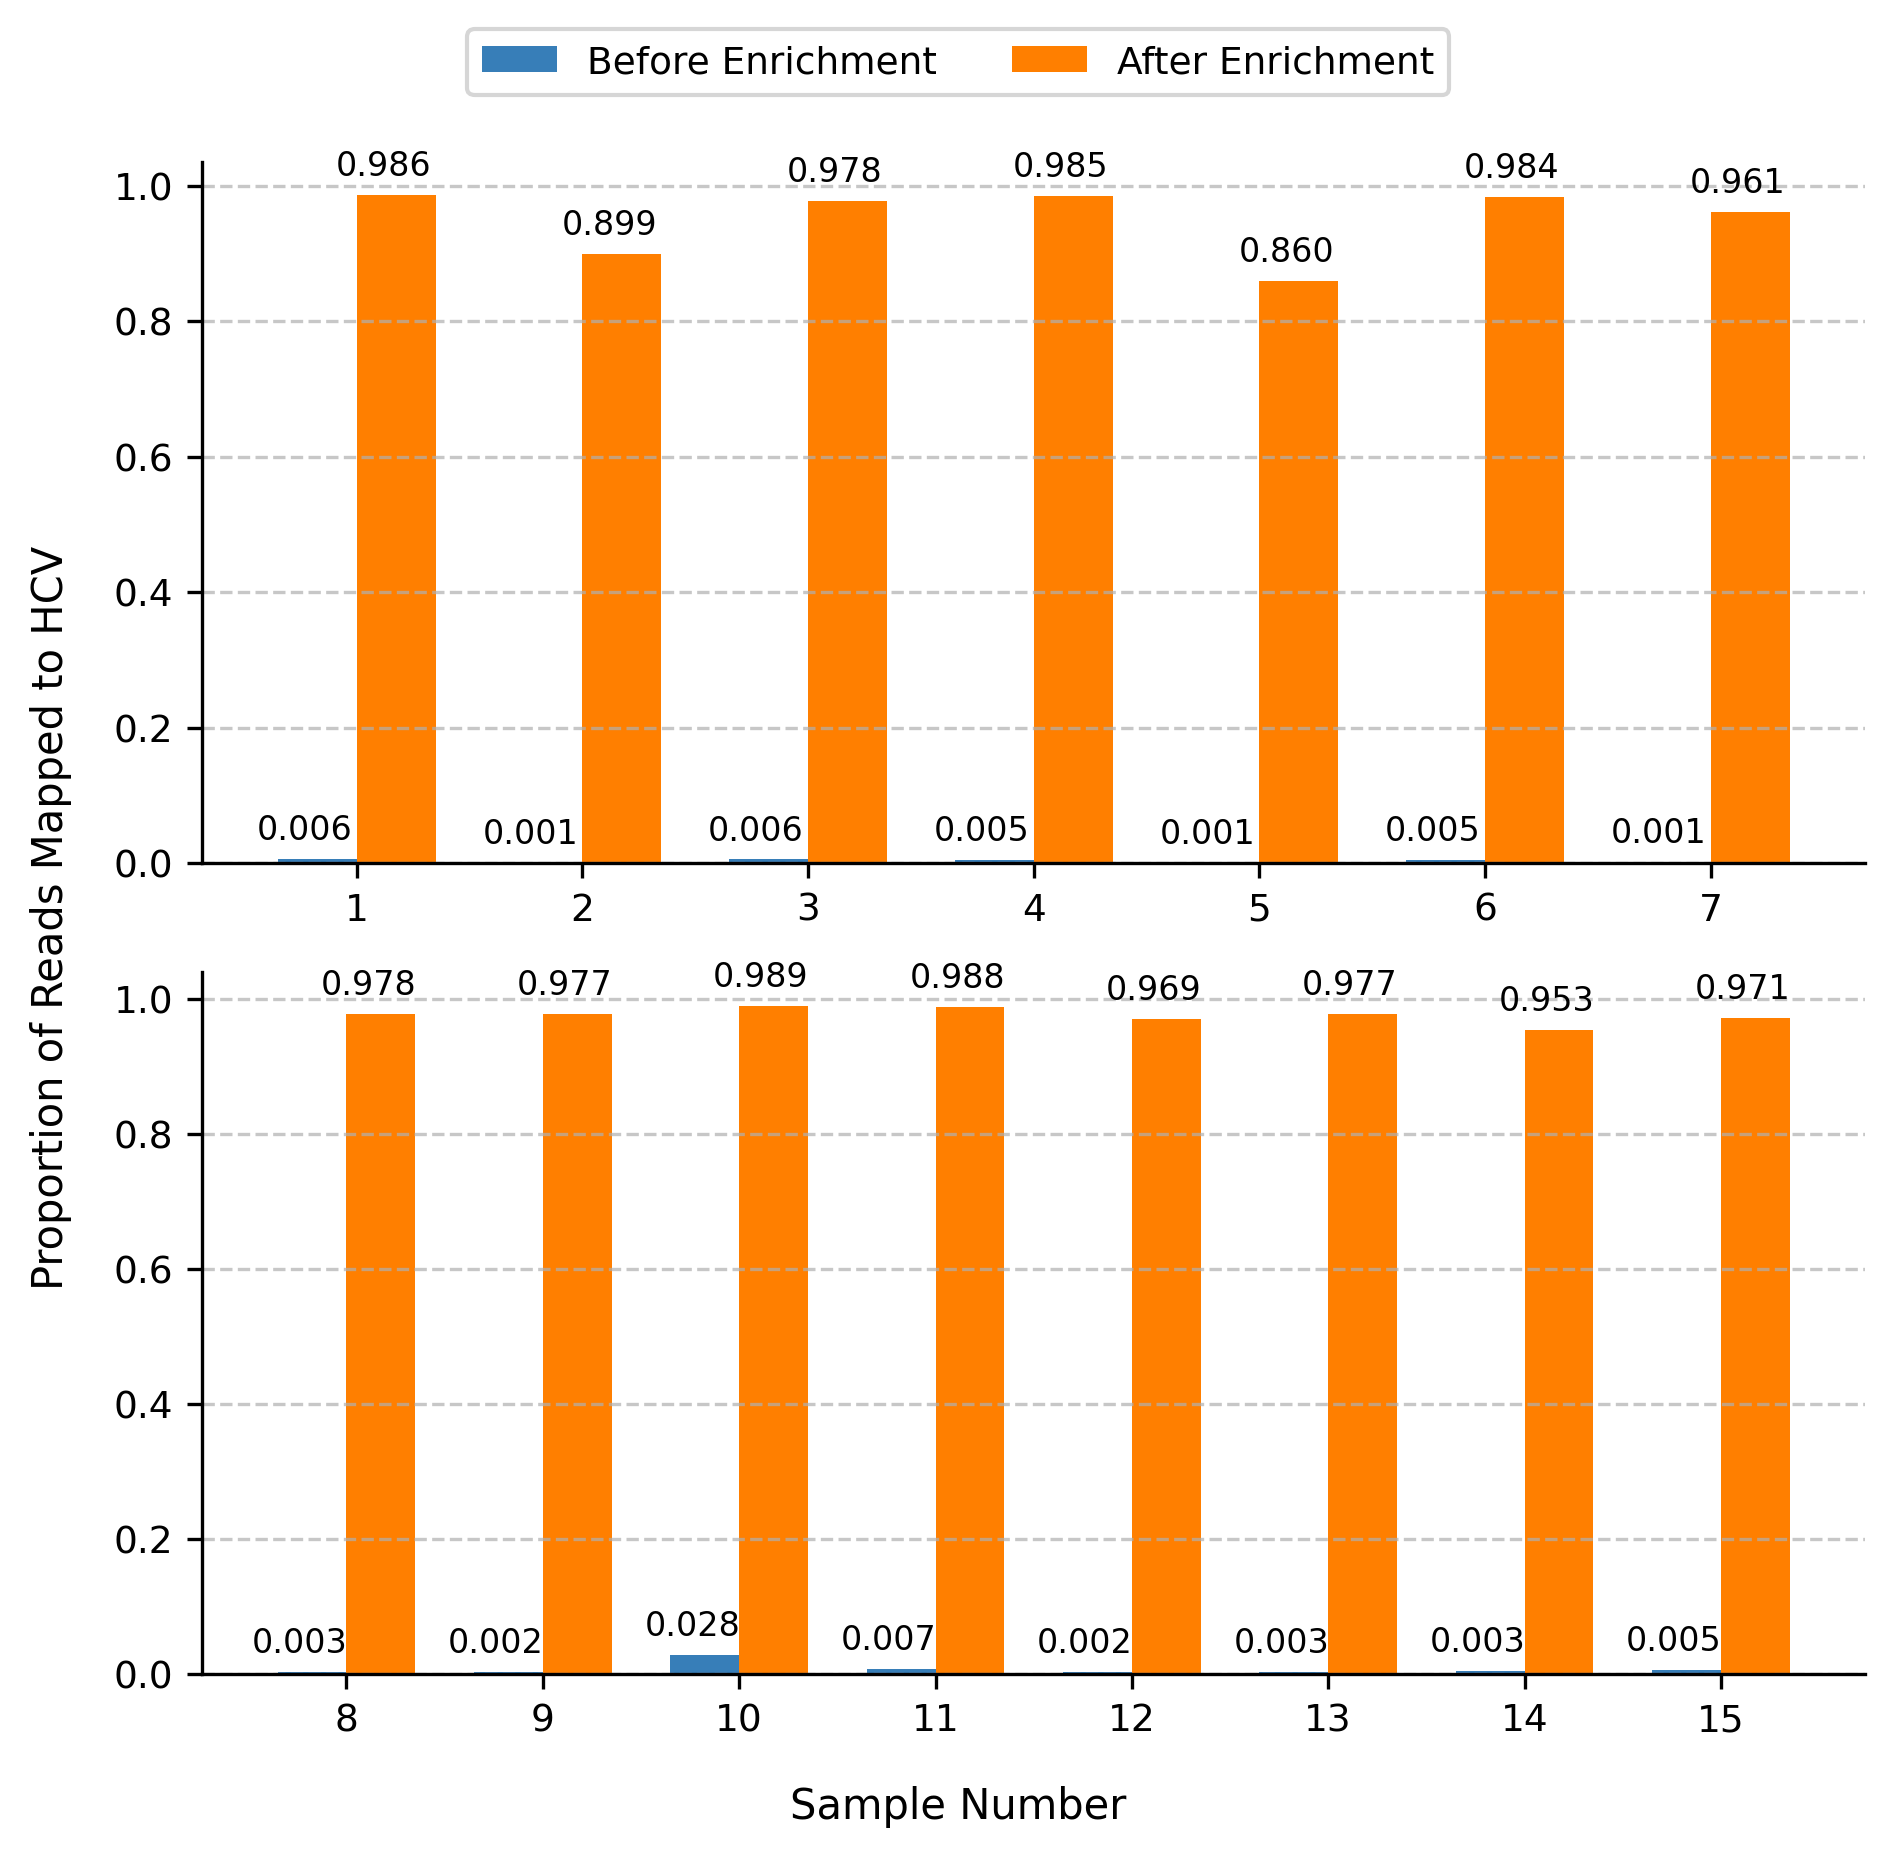

In [15]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

# Filter the data and prepare as before
before_enrichment = high_VL_samples[high_VL_samples["seq_method"] == "rep_2_precapture"]
after_enrichment = high_VL_samples[high_VL_samples["seq_method"] == "rep_2_G1a_capture"]
samples = sorted(
    set(before_enrichment["sample_id"]) & set(after_enrichment["sample_id"])
)

# Split samples into two groups
samples1 = samples[: len(samples) // 2]
samples2 = samples[len(samples) // 2 :]


def plot_group(ax, samples, before_enrichment, after_enrichment, start_number):
    x = np.arange(len(samples))
    width = 0.35

    before_values = [
        before_enrichment[before_enrichment["sample_id"] == sample][
            "prop_hcv_all"
        ].values[0]
        for sample in samples
    ]
    after_values = [
        after_enrichment[after_enrichment["sample_id"] == sample][
            "prop_hcv_all"
        ].values[0]
        for sample in samples
    ]

    rects1 = ax.bar(
        x - width / 2, before_values, width, label="Before Enrichment", color="#377eb8"
    )
    rects2 = ax.bar(
        x + width / 2, after_values, width, label="After Enrichment", color="#ff7f00"
    )

    ax.set_xticks(x)
    ax.set_xticklabels([f"{i+start_number}" for i in range(len(samples))], ha="center")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.7, zorder=0)

    for rects in [rects1, rects2]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height:.3f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(-3, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=8,
            )


centimeters = 1 / 2.54
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(16 * centimeters, 16 * centimeters), dpi=300
)

plot_group(ax1, samples1, before_enrichment, after_enrichment, 1)
plot_group(ax2, samples2, before_enrichment, after_enrichment, len(samples1) + 1)

fig.text(0.5, 0.03, "Sample Number", ha="center", va="center")
fig.text(
    0.02,
    0.5,
    "Proportion of Reads Mapped to HCV",
    ha="center",
    va="center",
    rotation="vertical",
)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.98), ncol=2)

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.98)

plt.show()

## human reads before and after enrichment

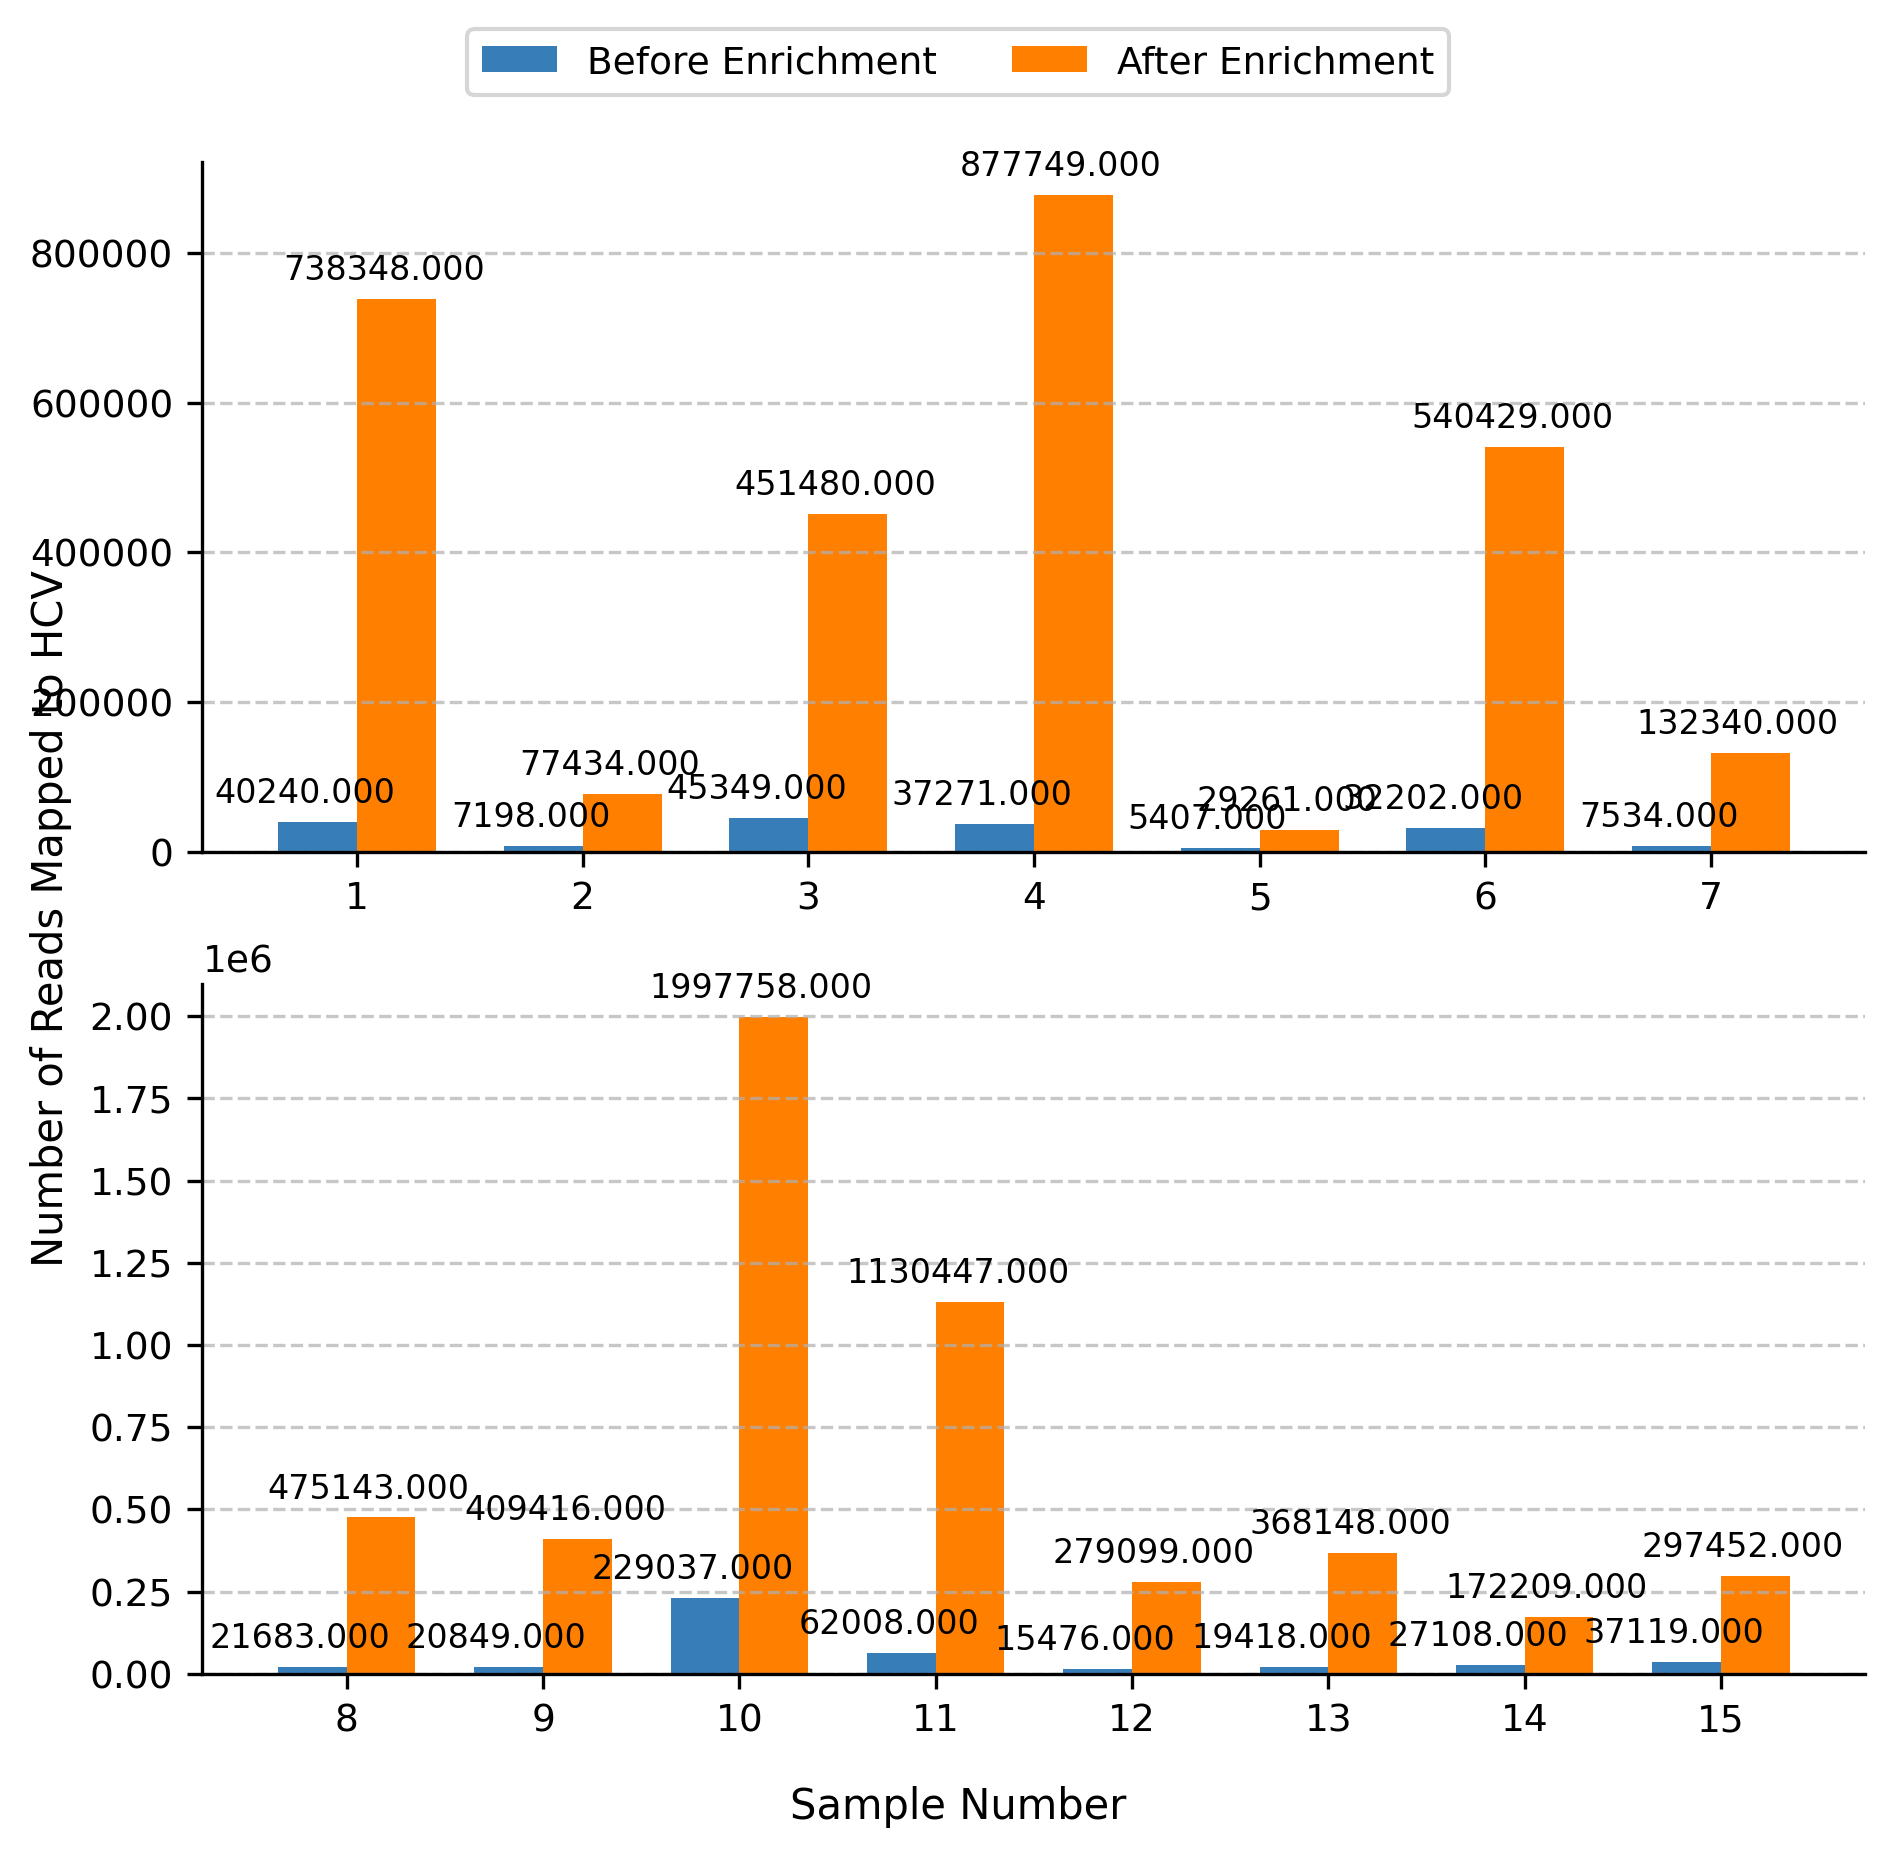

In [13]:
# Set global font sizes
rcParams["font.size"] = 10
rcParams["axes.titlesize"] = 12
rcParams["axes.labelsize"] = 10
rcParams["xtick.labelsize"] = 9
rcParams["ytick.labelsize"] = 9
rcParams["legend.fontsize"] = 9
rcParams["figure.titlesize"] = 14

# Filter the data and prepare as before
before_enrichment = high_VL_samples[high_VL_samples["seq_method"] == "rep_2_precapture"]
after_enrichment = high_VL_samples[high_VL_samples["seq_method"] == "rep_2_G1a_capture"]
samples = sorted(
    set(before_enrichment["sample_id"]) & set(after_enrichment["sample_id"])
)

# Split samples into two groups
samples1 = samples[: len(samples) // 2]
samples2 = samples[len(samples) // 2 :]


def plot_group(ax, samples, before_enrichment, after_enrichment, start_number):
    x = np.arange(len(samples))
    width = 0.35

    before_values = [
        before_enrichment[before_enrichment["sample_id"] == sample][
            "num_reads_mapped_to_HCV"
        ].values[0]
        for sample in samples
    ]
    after_values = [
        after_enrichment[after_enrichment["sample_id"] == sample][
            "num_reads_mapped_to_HCV"
        ].values[0]
        for sample in samples
    ]

    rects1 = ax.bar(
        x - width / 2, before_values, width, label="Before Enrichment", color="#377eb8"
    )
    rects2 = ax.bar(
        x + width / 2, after_values, width, label="After Enrichment", color="#ff7f00"
    )

    ax.set_xticks(x)
    ax.set_xticklabels([f"{i+start_number}" for i in range(len(samples))], ha="center")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.7, zorder=0)

    for rects in [rects1, rects2]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height:.3f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(-3, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=8,
            )


centimeters = 1 / 2.54
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(16 * centimeters, 16 * centimeters), dpi=300
)

plot_group(ax1, samples1, before_enrichment, after_enrichment, 1)
plot_group(ax2, samples2, before_enrichment, after_enrichment, len(samples1) + 1)

fig.text(0.5, 0.03, "Sample Number", ha="center", va="center")
fig.text(
    0.02,
    0.5,
    "Number of Reads Mapped to HCV",
    ha="center",
    va="center",
    rotation="vertical",
)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.98), ncol=2)

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.98)

plt.show()